In [1]:
import pandas as pd


data = pd.read_csv('monodata/mammographic.csv', header=None)

In [2]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


X = data.iloc[:, :-1]
y = data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## XGBoost

In [3]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

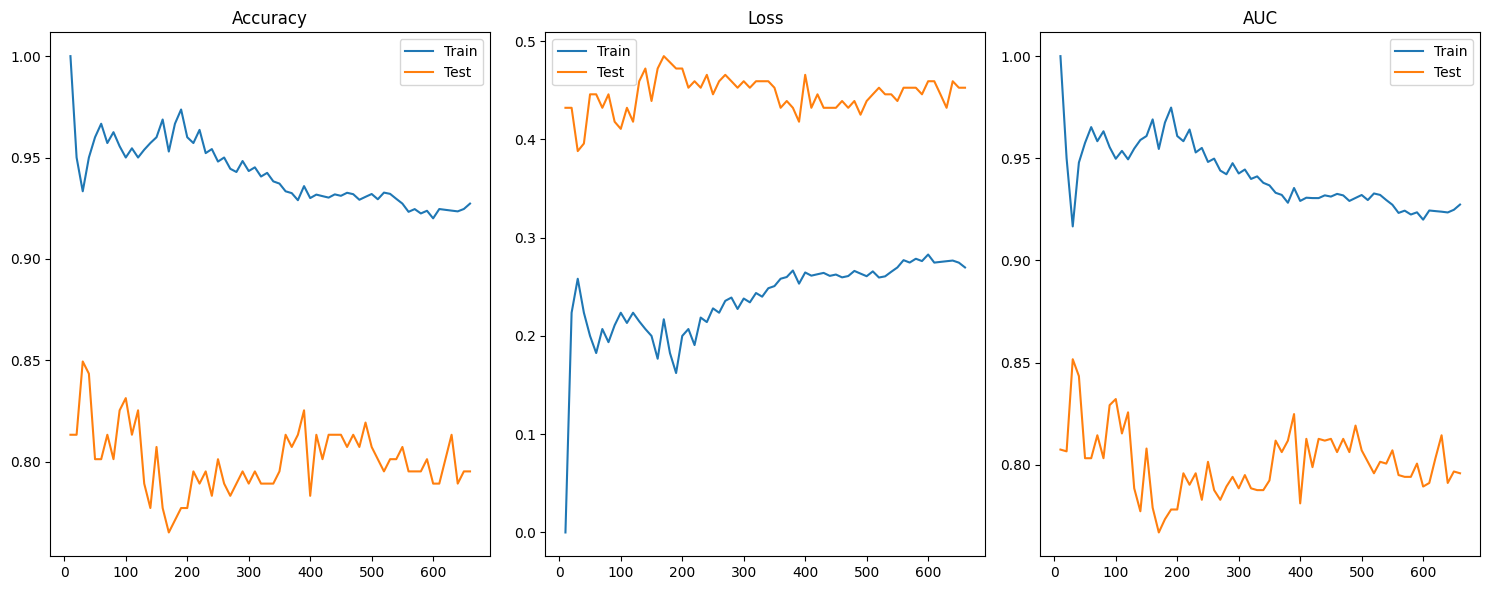

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import root_mean_squared_error

# Initialize lists to store metrics
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []
train_aucs = []
test_aucs = []

# Number of samples to take in each iteration
samples = list(range(10, len(X_train), 10))

for i in samples:
    # Train the model with i samples
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train[:i], y_train[:i])

    # Make predictions
    y_train_pred = model.predict(X_train[:i])
    y_test_pred = model.predict(X_test)

    # Calculate metrics
    train_accuracy = accuracy_score(y_train[:i], y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_loss = root_mean_squared_error(y_train[:i], y_train_pred)
    test_loss = root_mean_squared_error(y_test, y_test_pred)
    train_auc = roc_auc_score(y_train[:i], y_train_pred)
    test_auc = roc_auc_score(y_test, y_test_pred)

    # Append metrics to the lists
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_aucs.append(train_auc)
    test_aucs.append(test_auc)


fig = plt.figure(figsize=(15, 6))

# Plot accuracy
ax = fig.add_subplot(131)
ax.plot(samples, train_accuracies, label='Train')
ax.plot(samples, test_accuracies, label='Test')
ax.set_title('Accuracy')
ax.legend()

# Plot loss
ax = fig.add_subplot(132)
ax.plot(samples, train_losses, label='Train')
ax.plot(samples, test_losses, label='Test')
ax.set_title('Loss')
ax.legend()

# Plot AUC
ax = fig.add_subplot(133)
ax.plot(samples, train_aucs, label='Train')
ax.plot(samples, test_aucs, label='Test')
ax.set_title('AUC')
ax.legend()

plt.tight_layout()
plt.show()

## ANN-Ch-Constr

In [5]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

class LinearGreaterThanZero(nn.Linear):

    def __init__(self,in_features:int, bias:bool=False, min_w:float=0.0000001):
        super().__init__(in_features,1, bias)
        self.is_bias = bias
        self.min_w = min_w
        if bias:
            nn.init.uniform_(self.bias, self.min_w ,1.)
        else:
            self.bias = None

    def reset_parameters(self):
        nn.init.uniform_(self.weight, 0.1,1.)


    def w(self)->torch.Tensor:
        with torch.no_grad():
            self.weight.data[self.weight.data<0]=self.min_w
        return self.weight

    def forward(self, input:torch.Tensor)->torch.Tensor:
        return F.linear(input, self.w(), self.bias)


In [6]:
class LinearInteraction(nn.Linear):

    def __init__(self,in_features:int, criterion_layer:LinearGreaterThanZero):
        super().__init__(((in_features-1)*in_features)//2,1, False)
        self.in_features = in_features
        self.criterion_layer = criterion_layer
        
    def reset_parameters(self):
        nn.init.normal_(self.weight, 0.0,0.1)     
    
    def w(self)->torch.Tensor:
        with torch.no_grad():
            w_i=0
            w = self.criterion_layer.w()
            for i in range(self.in_features):
                for j in range(i+1,self.in_features):
                    self.weight.data[:,w_i] =  torch.max(self.weight.data[:,w_i], -w[:,i])
                    self.weight.data[:,w_i] =  torch.max(self.weight.data[:,w_i], -w[:,j])
                    w_i+=1
        return self.weight
        
    def forward(self, input:torch.Tensor)->torch.Tensor:
        return F.linear(input, self.w(), None)

In [7]:
from threshold_layer import ThresholdLayer

class ChoquetIntegralConstrained(nn.Module):
    def __init__(self, num_criteria:int):
        super().__init__()
        self.num_criteria = num_criteria
        self.criteria_layer = LinearGreaterThanZero(num_criteria)
        self.interaction_layer = LinearInteraction(num_criteria,self.criteria_layer)
        self.threshold_layer = ThresholdLayer()
    
    def forward(self, input:torch.Tensor)->torch.Tensor:
        if len(input.shape)==3:
            input = input[:,0,:]
        
        # Calculate the criteria part of integral
        x_wi = self.criteria_layer(input[:,:self.num_criteria])     
        # Calculate the interaction part of integral 
        x_wij = self.interaction_layer(input[:,self.num_criteria:])
        # Normalize scores
        weight_sum = self.criteria_layer.w().sum()+self.interaction_layer.w().sum()
        score =  (x_wi+x_wij)/(weight_sum)
        return self.threshold_layer(score)

In [8]:
import numpy as np

def mobious_transform(row:list|np.ndarray)->list:
    return  list(row) + [min(row[i],row[j]) for i in range(len(row)) for j in range(i+1,len(row))]

In [10]:
from utils import *

num_criteria = X.shape[1]

data_input = data.iloc[:,:num_criteria].apply(lambda x: mobious_transform(x),axis=1, result_type ='expand')
data_target = data.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(data_input.values,
                                                    data_target.values,
                                                    test_size=0.2,
                                                    random_state=1234)

train_dataloader = CreateDataLoader(X_train, y_train)
test_dataloader = CreateDataLoader(X_test, y_test)

In [11]:
model = ChoquetIntegralConstrained(num_criteria)
best_acc, best_auc,stats_train, stats_test, = Train(model, train_dataloader, test_dataloader, 'choquet.pt', lr=0.01, epoch_nr=50)

100%|██████████| 50/50 [00:01<00:00, 25.89it/s]


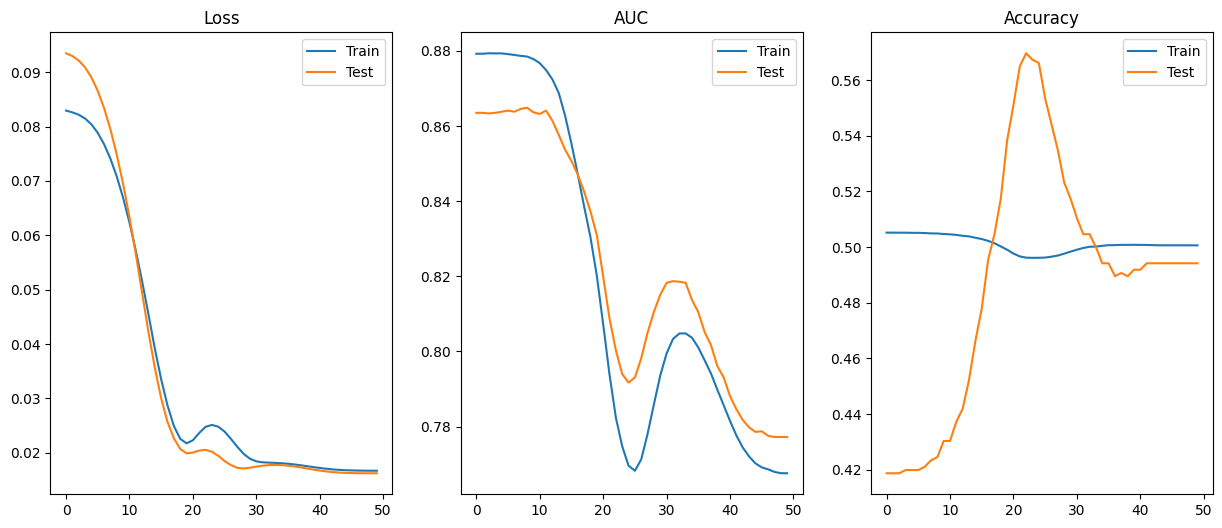

In [12]:
fig = plt.figure(figsize=(15,6))

ax = fig.add_subplot(131)
ax.plot(stats_train.losses,label='Train')
ax.plot(stats_test.losses,label='Test')
ax.set_title('Loss')
ax.legend()

ax = fig.add_subplot(1,3,2)
ax.plot(stats_train.auc_scores,label='Train')
ax.plot(stats_test.auc_scores,label='Test')
ax.set_title('AUC')
ax.legend()

ax = fig.add_subplot(1,3,3)
ax.plot(stats_train.acc_scores,label='Train')
ax.plot(stats_test.acc_scores,label='Test')
ax.set_title('Accuracy')
ax.legend()